# Notebook: Model Evaluation & Forecasting

### Models Compared
- **Linear regression** – simple baseline.
- **Ridge regression** – regularized linear model with time-aware CV.
- **XGBoost** – gradient boosting with delta-target and early stopping.
- **Prophet** – annual time series forecast (currently US aggregate only).

### Outputs
1. **Metrics Table** — MAE, MSE, RMSE, R², and MAPE for the test window (saved to `../models/metrics.csv`).
2. **Plots**  
   - Actual vs. Predicted (all models).  
   - Residuals for the top model (Linear baseline in this milestone).

---

## Prerequisites
- Project virtualenv (`.venv`) activated.
- Dependencies in `pyproject.toml`, including:
  - `ipykernel >= 6.29`
  - `jinja2 >= 3.1`
  - `pandas`, `numpy`, `matplotlib`, `scikit-learn`, `xgboost`, `prophet`
- PostgreSQL with feature matrix materialized view: `ml.feature_matrix`.
- Trained model artifacts in `../models/`:
  - `linear_model.pkl`
  - `ridge_model.pkl`
  - `xgb_model.pkl` (delta-target; includes `use_delta=True`)
  - `prophet_forecast.csv` (with `ds` + `yhat`, notebook derives `year`)

---

## How to Run
1. Open the notebook kernel for `.venv`.
2. Set GEO (default `"US"`) and SPLIT_YEAR (default `2020`).
3. Run all cells. The notebook will:
   - Query actuals from Postgres.
   - Load model artifacts.
   - Generate predictions and metrics.
   - Save metrics table to `../models/metrics.csv`.
   - Render charts.

---

## Notes
- Prophet forecasts are annual, US-only at this stage. Ridge/XGB/Linear can run per-geo.
- Extending Prophet to the full hierarchy is a later milestone.


In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ppp_common.orm import engine  # shared SQLAlchemy engine
from ppp_ml.utils import regression_metrics

###CONFIG###
GEO = "US"
SPLIT_YEAR = 2020

# model artifact paths
P_LINEAR  = "../models/linear_model.pkl"
P_RIDGE   = "../models/ridge_model.pkl"
P_XGB     = "../models/xgb_model.pkl"
P_PROPHET = "../models/prophet_forecast.csv"



In [5]:
###LOAD FEATURES###
with engine.begin() as conn:
    fm = pd.read_sql(
        """
        SELECT geo_code, year,
               population,
               pop_lag1, pop_lag5, pop_ma3,
               pop_yoy_growth_pct, pop_cagr_5yr_pct,
               unemployment_rate, rent_cpi_index
        FROM ml.feature_matrix
        WHERE geo_code = %(geo)s
        ORDER BY year
        """,
        conn,
        params={"geo": GEO},
    )

fm.head()

def load_artifact(path: str):
    with open(path, "rb") as f:
        art = pickle.load(f)
    # expected keys: "model", "features", maybe "use_delta" (for xgb)
    return art

def predict_with_artifact(art: dict, frame: pd.DataFrame) -> pd.Series:
    feats = art["features"]
    X = frame[feats].to_numpy(dtype="float64")
    yhat = art["model"].predict(X)  # for xgb wrapper: this returns DELTA
    # if delta target, add back base (pop_lag1) aligned to input rows
    if art.get("use_delta", False):
        base = frame.loc[:, "pop_lag1"].to_numpy(dtype="float64")
        yhat = yhat + base
    return pd.Series(yhat, index=frame.index, name="yhat")



“Prophet forecasts are included at the US aggregate level only. Ridge and XGBoost can be trained per geography. For demonstration in this milestone, I focus on comparing models at the national level; expanding Prophet to state and county hierarchies would be a natural extension.”

In [8]:
###BUILD TRAIN TESTS, SPLIT ONCE###
train = fm[fm["year"] < SPLIT_YEAR].copy()
test  = fm[fm["year"] >= SPLIT_YEAR].copy()

y_train = train["population"].to_numpy(dtype="float64")
y_test  = test["population"].to_numpy(dtype="float64")

###LOAD ARTIFACTS AND PREDICT###
# Linear
lin_art = load_artifact(P_LINEAR)
test["yhat_linear"] = predict_with_artifact(lin_art, test)

# Ridge
rid_art = load_artifact(P_RIDGE)
test["yhat_ridge"] = predict_with_artifact(rid_art, test)

# XGB (delta target => helper adds pop_lag1 back)
xgb_art = load_artifact(P_XGB)
test["yhat_xgb"] = predict_with_artifact(xgb_art, test)

# Prophet forecast CSV
prophet = pd.read_csv(P_PROPHET)

# Convert 'ds' (date string) to datetime and extract year
prophet["year"] = pd.to_datetime(prophet["ds"]).dt.year

# Keep only year + yhat, and rename
prophet = prophet.rename(columns={"yhat": "yhat_prophet"})[["year", "yhat_prophet"]]

# Merge with test set
test = test.merge(prophet, on="year", how="left")


model,mae,mse,rmse,r2,mape
linear,"95,392","11,090,856,185","105,313",0.999,0.03%
ridge,"157,774","37,418,560,245","193,439",0.998,0.05%
prophet,"899,763","875,815,135,597","935,850",0.955,0.27%
xgb,"2,314,571","6,909,486,286,115","2,628,590",0.641,0.70%


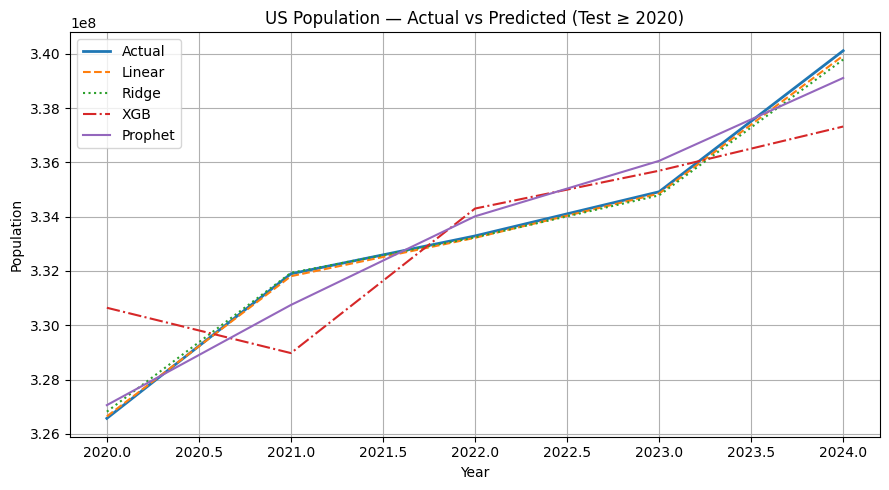

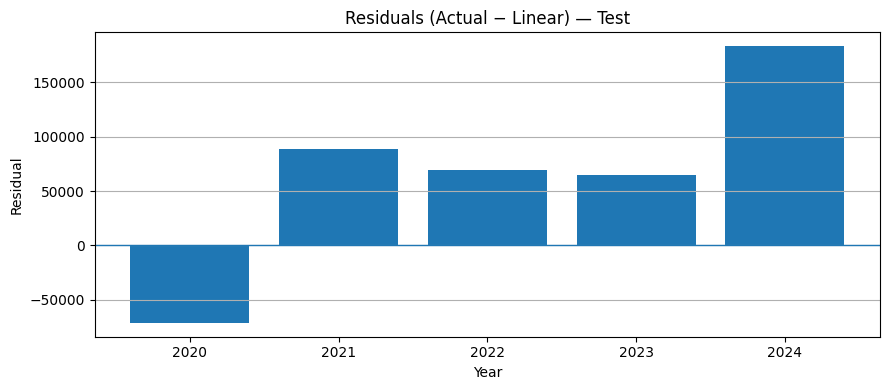

In [11]:
###PLOT METRICS TABLE###
rows = []
for name, col in [("linear","yhat_linear"),
                  ("ridge","yhat_ridge"),
                  ("xgb","yhat_xgb"),
                  ("prophet","yhat_prophet")]:
    if col in test and test[col].notna().any():
        m = regression_metrics(test["population"].to_numpy("float64"),
                               test[col].to_numpy("float64"))
        m["model"] = name
        rows.append(m)

metrics_df = (pd.DataFrame(rows)
                .loc[:,["model","mae","mse","rmse","r2","mape"]]
                .sort_values("mae"))

#log metrics
metrics_df.to_csv("../models/metrics.csv", index=False)

display(metrics_df.style.format({
    "mae": "{:,.0f}", "mse": "{:,.0f}", "rmse": "{:,.0f}",
    "r2": "{:.3f}", "mape": "{:.2f}%"
}).hide(axis="index"))

###forecasted vs actual + residuals###
plt.figure(figsize=(9,5))
plt.plot(test["year"], test["population"], label="Actual", linewidth=2)
for col,label,style in [("yhat_linear","Linear","--"),
                        ("yhat_ridge","Ridge",":"),
                        ("yhat_xgb","XGB","-."),
                        ("yhat_prophet","Prophet","-")]:
    if col in test and test[col].notna().any():
        plt.plot(test["year"], test[col], linestyle=style, label=label)
plt.title(f"{GEO} Population — Actual vs Predicted (Test ≥ {SPLIT_YEAR})")
plt.xlabel("Year"); plt.ylabel("Population")
plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

if "yhat_linear" in test:
    res = test["population"] - test["yhat_linear"]
    plt.figure(figsize=(9,4))
    plt.bar(test["year"], res)
    plt.axhline(0, linewidth=1)
    plt.title("Residuals (Actual − Linear) — Test")
    plt.xlabel("Year"); plt.ylabel("Residual")
    plt.grid(True, axis="y")
    plt.tight_layout(); plt.show()

git commit -m "eval: add metrics (MAE/MSE/RMSE/R²/MAPE) and model_eval notebook; fix engine usage and load all 4 models (delta-aware XGB)"
